<a href="https://colab.research.google.com/github/itzrnvr/opencv-labs/blob/main/lab11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image Denoising, Video Frame Extraction, Video Frame Processing, Crowd Analysis

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import restoration, metrics, img_as_float
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

In [4]:
PATH_IMG_SINGLE = 'image1.jpg'
PATH_VIDEO = 'pedestrian.mp4'
FOLDER_FRAMES = 'extracted_frames'
FOLDER_PROCESSED = 'processed_frames'
PATH_PROCESSED_VIDEO = 'processed_video.mp4'
YOLO_DARKNET_REPO = 'https://github.com/AlexeyAB/darknet.git'
YOLO_WEIGHTS = 'yolov4.weights'
YOLO_CONFIG = 'cfg/yolov4.cfg'
YOLO_OUTPUT = 'output_video.mp4'

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
Median:
  PSNR: 24.5561, SSIM: 0.5828, MSE: 0.003503

Wavelet:
  PSNR: 25.7112, SSIM: 0.6830, MSE: 0.002685

Noise2Void:
  PSNR: 20.6815, SSIM: 0.7669, MSE: 0.008548



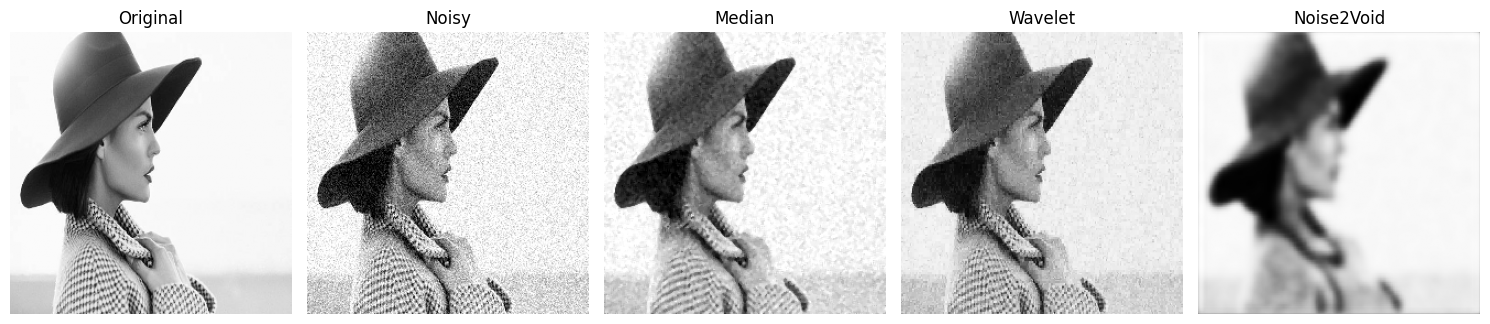

In [5]:
img = cv2.resize(cv2.imread(PATH_IMG_SINGLE, 0), (256,256))
img_f = img_as_float(img)
rng = np.random.normal(0, 1, img_f.shape)
ns_img = np.clip(img_f + 0.1 * rng, 0, 1)
mdn = cv2.medianBlur((ns_img * 255).astype(np.uint8), 3) / 255.0
wvn = restoration.denoise_wavelet(ns_img, method='BayesShrink', mode='soft', rescale_sigma=True)
xdata = ns_img.reshape(1, 256, 256, 1)
ydata = img_f.reshape(1, 256, 256, 1)
inn = Input(shape=(256,256,1))
lay = Conv2D(64, 3, activation='relu', padding='same')(inn)
lay = MaxPooling2D(2)(lay)
lay = Conv2D(32, 3, activation='relu', padding='same')(lay)
lay = MaxPooling2D(2)(lay)
lay = Conv2D(32, 3, activation='relu', padding='same')(lay)
lay = UpSampling2D(2)(lay)
lay = Conv2D(64, 3, activation='relu', padding='same')(lay)
lay = UpSampling2D(2)(lay)
outn = Conv2D(1, 3, activation='sigmoid', padding='same')(lay)
aemod = Model(inn, outn)
aemod.compile(optimizer='adam', loss='mse')
aemod.fit(xdata, ydata, epochs=50, verbose=0)
pred_noisefree = aemod.predict(xdata)[0,...,0]
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error
def evl(o, d):
    return (peak_signal_noise_ratio(o,d,data_range=1.), structural_similarity(o,d,data_range=1.), mean_squared_error(o,d))
rresults = {
    "Median": evl(img_f, mdn),
    "Wavelet": evl(img_f, wvn),
    "Noise2Void": evl(img_f, pred_noisefree)
}
for tag, (psnr, ssim, mse) in rresults.items():
    print(f"{tag}:\n  PSNR: {psnr:.4f}, SSIM: {ssim:.4f}, MSE: {mse:.6f}\n")
tl = ['Original', 'Noisy', 'Median', 'Wavelet', 'Noise2Void']
ims = [img_f, ns_img, mdn, wvn, pred_noisefree]
plt.figure(figsize=(15,6))
for idx,item in enumerate(ims):
    plt.subplot(1, 5, idx+1)
    plt.imshow(item, cmap='gray')
    plt.title(tl[idx])
    plt.axis('off')
plt.tight_layout()
plt.show()


Video Frame Extraction

In [6]:
if not os.path.exists(FOLDER_FRAMES):
    os.makedirs(FOLDER_FRAMES)
cap = cv2.VideoCapture(PATH_VIDEO)
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    idx = 0
    while True:
        ret, frm = cap.read()
        if not ret:
            break
        fname = os.path.join(FOLDER_FRAMES, f"frame_{idx:04d}.png")
        cv2.imwrite(fname, frm)
        idx += 1
    cap.release()
print(f"Frames extracted and saved in folder '{FOLDER_FRAMES}'.")


Frames extracted and saved in folder 'extracted_frames'.


Process Video Frames

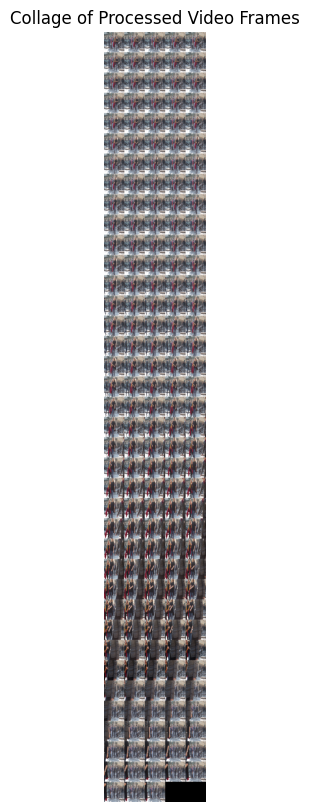

Processed video saved as 'processed_video.mp4'


In [7]:
if not os.path.exists(FOLDER_PROCESSED):
    os.makedirs(FOLDER_PROCESSED)
cap = cv2.VideoCapture(PATH_VIDEO)
recon_frames = []
count = 0
while True:
    status, imgf = cap.read()
    if not status:
        break
    grayf = cv2.cvtColor(imgf, cv2.COLOR_BGR2GRAY)
    adap_f = cv2.adaptiveThreshold(grayf,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
    gaus_blur = cv2.GaussianBlur(imgf,(5,5),0)
    canny_f = cv2.Canny(grayf,100,200)
    not_f = cv2.bitwise_not(imgf)
    cv2.imwrite(os.path.join(FOLDER_PROCESSED, f'adaptive_thresh_{count:04d}.png'), adap_f)
    cv2.imwrite(os.path.join(FOLDER_PROCESSED, f'gaussian_blur_{count:04d}.png'), gaus_blur)
    cv2.imwrite(os.path.join(FOLDER_PROCESSED, f'canny_edges_{count:04d}.png'), canny_f)
    cv2.imwrite(os.path.join(FOLDER_PROCESSED, f'bitwise_not_{count:04d}.png'), not_f)
    recon_frames.append(gaus_blur)
    count += 1
cap.release()
cw = 5
ch = int(np.ceil(len(recon_frames)/cw))
canvas = np.zeros((ch*256, cw*256, 3), dtype=np.uint8)
for n, fr in enumerate(recon_frames):
    crow = n // cw
    ccol = n % cw
    canvas[crow*256:(crow+1)*256, ccol*256:(ccol+1)*256] = cv2.resize(fr, (256,256))
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Collage of Processed Video Frames')
plt.show()
vidw = cv2.VideoWriter(PATH_PROCESSED_VIDEO, cv2.VideoWriter_fourcc(*'mp4v'), 20.0, (256,256))
for fr in recon_frames:
    vidw.write(cv2.resize(fr, (256,256)))
vidw.release()
print(f"Processed video saved as '{PATH_PROCESSED_VIDEO}'")

Crowd Analysis with YOLOv4

In [ ]:
!pip install opencv-python-headless
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install pillow
!git clone {YOLO_DARKNET_REPO}
%cd darknet
!make
!wget https://pjreddie.com/media/files/yolov4.weights
import cv2
import numpy as np
net = cv2.dnn.readNetFromDarknet(YOLO_CONFIG, YOLO_WEIGHTS)


layern = net.getLayerNames()
outL = [layern[i-1] for i in net.getUnconnectedOutLayers()]
cap = cv2.VideoCapture(PATH_VIDEO)
outvid = cv2.VideoWriter(YOLO_OUTPUT, cv2.VideoWriter_fourcc(*'mp4v'), 20.0, (640,480))
while(cap.isOpened()):
    ret, fr = cap.read()
    if not ret:
        break
    blob = cv2.dnn.blobFromImage(fr, 0.00392, (416,416), (0,0,0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(outL)
    ids, confs, bxs = [], [], []
    for subo in outs:
        for det in subo:
            scs = det[5:]
            idx = np.argmax(scs)
            c = scs[idx]
            if c > 0.5:
                cx = int(det[0]*fr.shape[1]); cy = int(det[1]*fr.shape[0])
                w = int(det[2]*fr.shape[1]); h = int(det[3]*fr.shape[0])
                x = int(cx-w/2); y = int(cy-h/2)
                bxs.append([x, y, w, h])
                confs.append(float(c)); ids.append(idx)
    ix = cv2.dnn.NMSBoxes(bxs, confs, 0.5, 0.4)
    for k in ix.flatten():
        x, y, w, h = bxs[k]
        lbl = str(ids[k]); conf = confs[k]
        cv2.rectangle(fr, (x,y), (x+w,y+h), (0,255,0), 2)
        cv2.putText(fr, f'{lbl} {conf:.2f}', (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
    cv2.imshow('Crowd Monitoring - YOLOv4', fr)
    outvid.write(fr)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release(); outvid.release(); cv2.destroyAllWindows()
